In [424]:
import os
import pandas as pd
import plotting
import importlib
importlib.reload(plotting)
import math
import numpy as np

# Load in all depth vs resistance curves into a dataframe list

In [425]:
def load_data(data_src):
    depth_resist_curve_df_list = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        depth_resist_curve_df_list.append(df)
        filename_list.append(filename)
    return depth_resist_curve_df_list, filename_list

data_src = "data/cleaned_data"
depth_resist_curve_df_list, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, depth_resist_curve_df_list))

# Seperate clustering data from meta-data

In [426]:
data_features_df = pd.read_csv("data/features.csv")
metadata_list = ['filenames', 'feifeis_ylabels', 'liams_ylabels', 'marions_ylabels', 'distances']
clustering_features_df = data_features_df.drop(metadata_list, axis=1)

# Clustering Marion's Labels

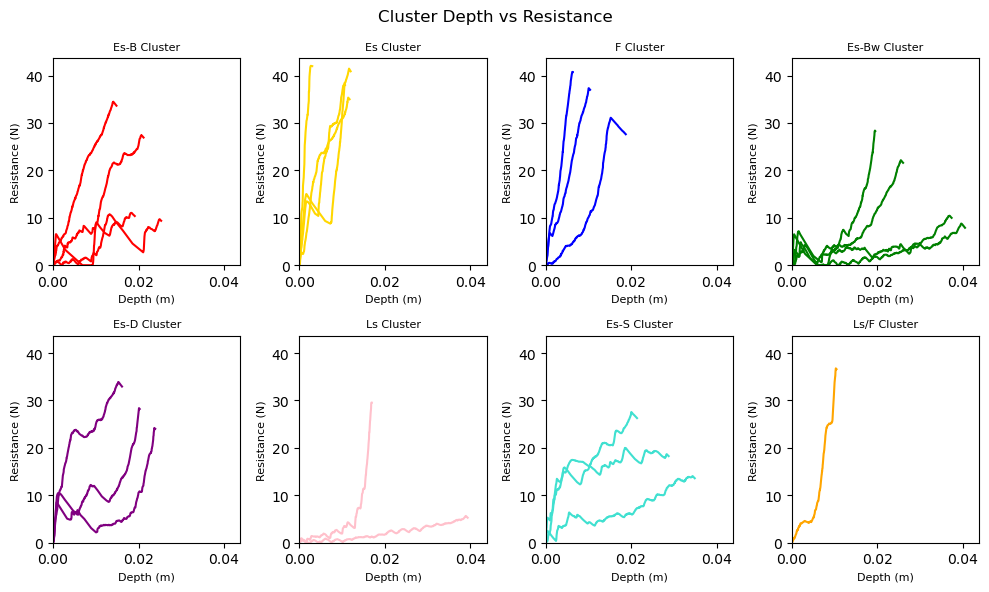

In [427]:
marions_labeled_data = data_features_df[data_features_df['marions_ylabels'].notna()].copy() # removes NaN's which correspond to non-labled data
# encodes object into categorical variables
marions_labeled_data['encoded'], uniques = pd.factorize(marions_labeled_data['marions_ylabels'])

plotting.plot_clusters_seperately(marions_labeled_data['encoded'].tolist(), marions_labeled_data.index.tolist(), depth_resist_curve_df_list, 
                         cluster_category_names=uniques.tolist())

def find_marions_labels_means(marions_labeled_data: pd.DataFrame) -> pd.DataFrame:
    # remove non-important cols
    marions_labeled_data = marions_labeled_data.copy()
    numerical_data = plotting.extract_numerical_features(marions_labeled_data)
    marions_labeled_data['encoded'], uniques = pd.factorize(marions_labeled_data['marions_ylabels'])
    label_centroids = []
    for label_num, label_name in enumerate(uniques):
        label_features = numerical_data[marions_labeled_data['encoded'] == label_num]
        label_centroid = label_features.mean(axis=0).tolist() # drop cols for mean calculation
        label_centroid.extend([label_name, label_num])

        label_centroids.append(label_centroid)
    return_cols = numerical_data.columns.tolist()
    return_cols.extend(['marions_ylabels', 'encoded'])
    return pd.DataFrame(data=label_centroids, columns=return_cols)

marions_label_centroids = find_marions_labels_means(marions_labeled_data)
plotting.plot_pca(marions_labeled_data, marions_labeled_data['encoded'], 3, graph_title='marions_ylabels', centroids=marions_label_centroids)

# Marion's Centroid Clustering

In [428]:

def euclidean_distance(x: pd.Series, y: pd.Series) -> float:
    return math.sqrt(((y - x) ** 2).sum())

def find_closest_centroid(unlabeled_data_df:pd.DataFrame, marions_centroids:pd.DataFrame) -> pd.DataFrame:
    unlabeled_data_df = unlabeled_data_df.copy()
    unlabeled_data_df = plotting.extract_numerical_features(unlabeled_data_df)
    
    psuedo_label_list = []
    psuedo_label_num_list = []
    unlabeled_data_df = unlabeled_data_df.copy()
    for i, depth_res_curve in unlabeled_data_df.iterrows():
        min_distance = float('inf')
        min_distance_label = ''
        min_distance_label_num = 0
        for j, marions_label_mean in marions_centroids.iterrows():
            curve_to_label_mean_distance = euclidean_distance(depth_res_curve, marions_label_mean)
            if curve_to_label_mean_distance < min_distance:
                min_distance = curve_to_label_mean_distance
                min_distance_label = marions_label_mean['marions_ylabels']
                min_distance_label_num = j
        psuedo_label_list.append(min_distance_label)
        psuedo_label_num_list.append(min_distance_label_num)
    unlabeled_data_df['marions_pseudo_labels'] = psuedo_label_list
    unlabeled_data_df['encoded'] = psuedo_label_num_list
    return unlabeled_data_df

psuedo_labeled_data = find_closest_centroid(data_features_df, marions_label_centroids)

# Find curves that moved categories

In [429]:
marions_ylabel_indicies = marions_labeled_data.index # indicies of labeled data points
marions_labeled_data = marions_labeled_data
psuedo_labeling_of_labeled_data = psuedo_labeled_data.loc[marions_ylabel_indicies]
diff_mask = (marions_labeled_data['marions_ylabels'] != psuedo_labeling_of_labeled_data['marions_pseudo_labels'])
diff_indicies = marions_labeled_data[diff_mask].index.tolist()
print(f'indicies where pseudo label differs from actual: {diff_indicies}')

indicies where pseudo label differs from actual: [0, 8, 26, 37, 43, 48, 55, 62, 71]


# Plotting with correction of labeled curves moving categories

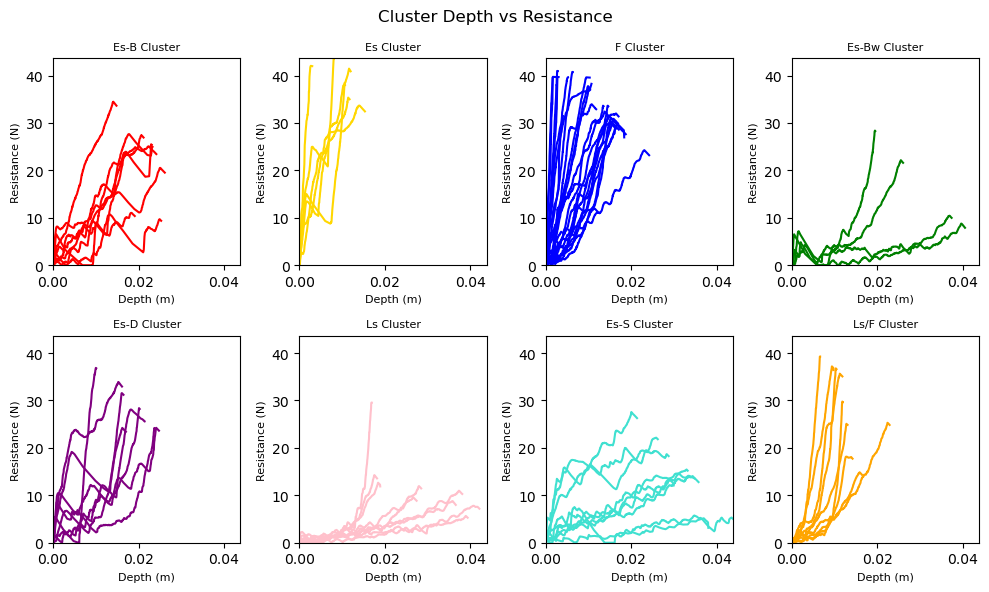

In [430]:
# plotting.pca_analysis(psuedo_labeled_data)
corrected_pseudo_labeling = psuedo_labeled_data.copy()

# correct movements of curves
corrected_pseudo_labeling.loc[diff_indicies, 'marions_pseudo_labels'] = marions_labeled_data['marions_ylabels']
corrected_pseudo_labeling.loc[diff_indicies, 'encoded'] = marions_labeled_data['encoded']

# plotting.plot_pca(corrected_pseudo_labeling, corrected_pseudo_labeling['encoded'], 3, 
#     graph_title='marions_psuedo_labels', centroids=marions_label_centroids)
plotting.plot_clusters_seperately(corrected_pseudo_labeling['encoded'], corrected_pseudo_labeling.index, 
                                  depth_resist_curve_df_list, cluster_category_names=marions_label_centroids['marions_ylabels'].tolist())

# Plotting with no correction of labeled curves moving categories

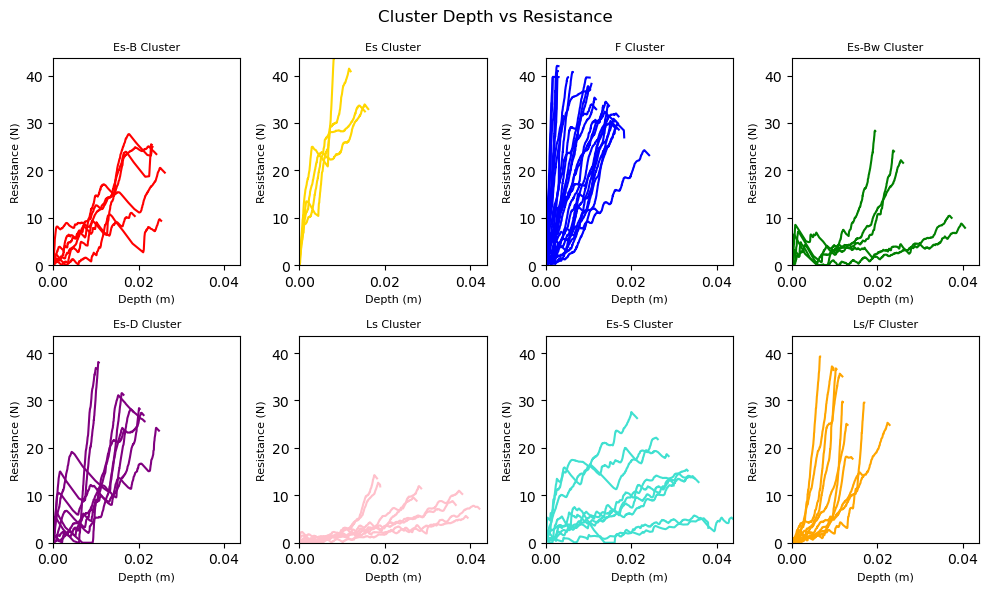

In [431]:
# plotting.pca_analysis(psuedo_labeled_data)
uncorrected_pseudo_labeling = psuedo_labeled_data.copy()

# plotting.plot_pca(uncorrected_pseudo_labeling, uncorrected_pseudo_labeling['encoded'], 3, 
#     graph_title='marions_psuedo_labels', centroids=marions_label_centroids)
plotting.plot_clusters_seperately(uncorrected_pseudo_labeling['encoded'], uncorrected_pseudo_labeling.index, 
                                  depth_resist_curve_df_list, cluster_category_names=marions_label_centroids['marions_ylabels'].tolist())

# Plotting with no correction of labeled curves moving categories & keeping cluster curve color

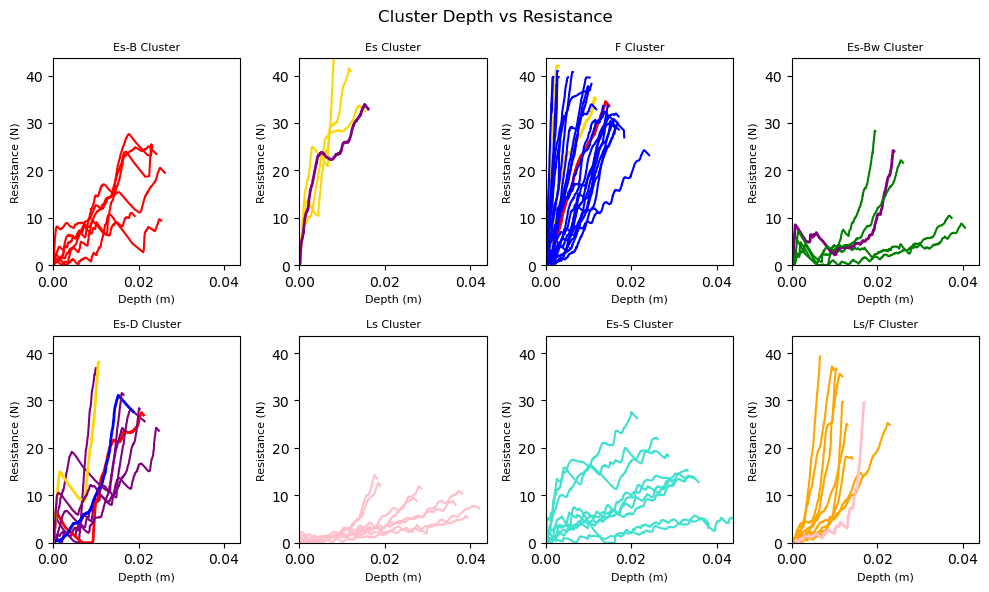

In [432]:
# plotting.pca_analysis(psuedo_labeled_data)
uncorrected_pseudo_labeling = psuedo_labeled_data.copy()

pseudo_corrections = marions_labeled_data.loc[diff_indicies]

# plotting.plot_pca(uncorrected_pseudo_labeling, uncorrected_pseudo_labeling['encoded'], 3, 
#     graph_title='marions_psuedo_labels', centroids=marions_label_centroids)
plotting.plot_clusters_seperately(uncorrected_pseudo_labeling['encoded'], uncorrected_pseudo_labeling.index, 
                                  depth_resist_curve_df_list, cluster_category_names=marions_label_centroids['marions_ylabels'].tolist(),
                                  pseudo_corrections=pseudo_corrections)